In [144]:
import scipy.io
import scipy.interpolate
import scipy as sc
import numpy as np
import h5py
import xarray as xr
import matplotlib as plt
import pandas as pd
import time

In [214]:
#loc_foot=foot.stack(z=("y","x"))
#loc_risk=risk.stack(z=("y","x"))
def interp_footprint(risk,foot,indx=0):
    X=risk.isel(z=indx).X.values
    Y=risk.isel(z=indx).Y.values

    tmp=sc.interpolate.griddata((foot.x.values+X,foot.y.values+Y),foot.prob.values,(risk.X.values,risk.Y.values))#,fill_value=0.)
    out= risk.copy()
    out['footprint']=('z',tmp)
    
    
    return out

def interp_to_footprint(risk,foot,indx=0):
    X=risk.isel(z=indx).X.values
    Y=risk.isel(z=indx).Y.values

    tmp=sc.interpolate.griddata((risk.X.values,risk.Y.values),risk.prob.values,(foot.x.values+X,foot.y.values+Y),fill_value=0.)
    out= foot.copy()
    out['risk']=('z',tmp)
    
    
    return out
    

In [223]:
tick=time.time()
out=interp_footprint(loc_map,qstack,indx=3650)
#out.unstack('z').risk.plot()
tock=time.time()
print(tock-tick)


0.02453017234802246


In [226]:
out.footprint.dropna(dim='z').unstack('z')

<xarray.DataArray 'footprint' (y: 8, x: 14)>
array([[0.00000000e+00,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.97423750e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00,            nan,            nan,            nan,
                   nan,            nan],
       [1.03429375e-02, 1.51388750e-02, 1.09716875e-02, 2.83729375e-02,
        3.42791250e-02, 4.49652500e-02, 3.86530625e-02, 3.06129375e-02,
        2.19627500e-02, 7.55954375e-03, 1.74012500e-02, 3.22976250e-02,
        1.34420000e-02,            nan],
       [1.15662500e-01, 5.38312500e-02, 8.08475000e-02, 1.71185000e-01,
        3.52417500e-01, 3.45712500e-03, 2.79380000e-02, 9.99790000e-01,
        8.53620000e-02,            nan, 0.00000000e+00, 2.70240000e-02,
        1.45072500e-02, 7.81900000e-03],
       [6.41386250e-02, 1.41926875e-02, 4.04312500e-02, 7.43239375e-02,
        4.76416250e-02,            nan, 7.10712500e-04, 2.80995625e-02,
        3.31055000e-02,            nan,            nan, 1.91896250e-02,
                   nan,            nan],
       [1.43810000e-03,            nan, 0.00000000e+00, 2.10715625e-03,
        8.83912500e-04,            nan,            nan, 2.26129375e-03,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan, 0.00000000e+00,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan]])
Coordinates:
    X        (y, x) float32 5.698e+05 nan nan nan nan ... nan nan nan nan nan
    Y        (y, x) float32 5.783e+06 nan nan nan nan ... nan nan nan nan nan
  * y        (y) int64 14 15 16 17 18 19 20 21
  * x        (x) int64 47 45 46 48 49 43 44 50 51 41 42 52 53 54

In [193]:
tick=time.time()
tmp=((1-out.footprint)/(1-out.prob.weighted(out.footprint).sum())).weighted(out.prob).sum()
print(time.time()-tick)
tmp

0.0165860652923584


<xarray.DataArray ()>
array(0.98999966)

In [190]:
tick=time.time()
tmp=(out.prob*(1.-out.footprint)/(1.-(out.prob*out.footprint).sum())).sum()
print(time.time()-tick)
tmp

0.007689952850341797


<xarray.DataArray ()>
array(0.98999966)

In [204]:
def calc_post(risk,foot,indx=0):
    out=interp_footprint(loc_map,qstack,indx=indx)
    p_post=(out.prob*(1.-out.footprint)/(1.-(out.prob*out.footprint).sum())).sum()
    #p_post=((1-out.footprint)/(1-(out.prob*out.footprint).sum()))*out.prob
    return p_post

In [209]:
loc_map

<xarray.Dataset>
Dimensions:               (z: 38600)
Coordinates:
    X                     (z) float32 5.697e+05 5.697e+05 ... 5.709e+05
    Y                     (z) float32 5.782e+06 5.782e+06 ... 5.782e+06
  * z                     (z) MultiIndex
  - y                     (z) int64 0 0 0 0 0 0 0 ... 192 192 192 192 192 192
  - x                     (z) int64 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    coordX                (z) float32 5.697e+05 5.697e+05 ... 5.709e+05
    coordY                (z) float32 5.782e+06 5.782e+06 ... 5.782e+06
    location_probability  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prob                  (z) float64 2.533e-05 2.533e-05 ... 2.533e-05

Read risk map

In [208]:
sums=np.ones(loc_map.sizes['z'])
tick=time.time()
for ii in np.arange(loc_map.sizes['z']):  
    tmp=calc_post(loc_map,qstack,indx=ii)
    sums[ii]=tmp
print(time.time()-tick)

    #sums[ii]=tmp.post.sum()

sums

KeyboardInterrupt: 

In [15]:
riskmap=xr.open_dataset('Riskmaps/320ktmig5aptnearstk_destriping_0_0075_amplitude_AGF_1_netcdf.nc').load()
riskmap.close()
riskmap=riskmap.assign_coords(X=riskmap.coordX)
riskmap=riskmap.assign_coords(Y=riskmap.coordY)

riskmap['prob']=riskmap.location_probability+0.001*riskmap.location_probability.sum()
riskmap['prob']=riskmap.prob/riskmap.prob.sum()
riskmap

<xarray.Dataset>
Dimensions:               (y: 193, x: 1289)
Coordinates:
    X                     (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    Y                     (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
Dimensions without coordinates: y, x
Data variables:
    coordX                (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    coordY                (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
    location_probability  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prob                  (y, x) float64 4.004e-06 4.004e-06 ... 4.004e-06

In [16]:
risk=riskmap.stack(z=("y","x"))

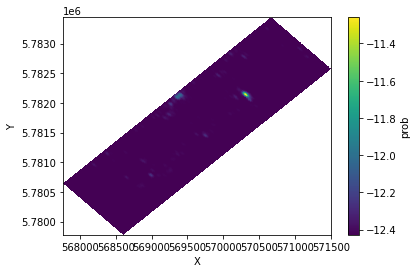

In [17]:
np.log(riskmap.prob).plot(x='X',y='Y')

Read foodprint 

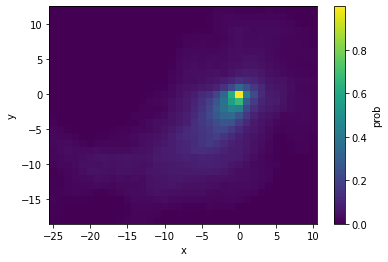

In [18]:
qq=xr.open_dataset('Original_Matlab/qq.nc').load().transpose()
qq.close()
qq['x']=qq.x/1000
qq['y']=qq.y/1000
qq.prob.plot()

In [19]:
qstack=   qq.stack(z=("y","x"))
qstack

<xarray.Dataset>
Dimensions:  (z: 1116)
Coordinates:
  * z        (z) MultiIndex
  - y        (z) float64 -18.0 -18.0 -18.0 -18.0 -18.0 ... 12.0 12.0 12.0 12.0
  - x        (z) float64 -25.0 -24.0 -23.0 -22.0 -21.0 ... 6.0 7.0 8.0 9.0 10.0
Data variables:
    prob     (z) float64 0.001886 0.0 0.0 0.0 0.0 ... 0.002981 0.001419 0.0 0.0

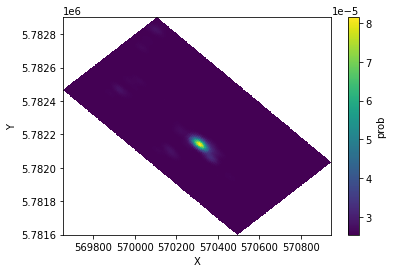

In [20]:

loc_map=riskmap.isel(x=840+np.arange(200))
loc_map['prob']=0.99*loc_map.prob/loc_map.prob.sum()

loc_map.prob.plot(x='X',y='Y')
loc_map=loc_map.stack(z=("y","x"))

In [37]:
loc_map.isel(z=10).X

<xarray.DataArray 'X' ()>
array(569682.44, dtype=float32)
Coordinates:
    X        float32 5.697e+05
    Y        float32 5.782e+06
    z        object (0, 10)

In [35]:
tmp=loc_map.copy()
tmp['foot']=('z', sc.interpolate.griddata((qstack.x.values+pos.X.values,qstack.y.values+pos.Y.values),qstack.prob.values,(risk.X.values,risk.Y.values),fill_value=0))

ValueError: conflicting sizes for dimension 'z': length 248777 on 'foot' and length 38600 on {'z': 'coordX'}

In [155]:
(((1-tmp.foot)/(1-(tmp.prob*tmp.foot).sum())-1)*tmp.prob).sum()


In [33]:
loc_max=loc_map.prob.argmax(...)
loc_max['z']

<xarray.DataArray 'prob' ()>
array(22078)

In [34]:
pos=loc_map.isel(z=loc_max['z'])
pos

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    X                     float32 5.703e+05
    Y                     float32 5.782e+06
    z                     object (110, 78)
Data variables:
    coordX                float32 5.703e+05
    coordY                float32 5.782e+06
    location_probability  float32 0.0009206
    prob                  float64 8.15e-05

In [11]:
grid_x, grid_y = np.meshgrid(qq.x, qq.y)
np.shape(grid_x)

(31, 36)

In [12]:
loc_map.x.max()-loc_map.x.min()

<xarray.DataArray 'x' ()>
array(199)

In [13]:
grid_x+pos.X.values

array([[570287.625, 570288.625, 570289.625, ..., 570320.625, 570321.625,
        570322.625],
       [570287.625, 570288.625, 570289.625, ..., 570320.625, 570321.625,
        570322.625],
       [570287.625, 570288.625, 570289.625, ..., 570320.625, 570321.625,
        570322.625],
       ...,
       [570287.625, 570288.625, 570289.625, ..., 570320.625, 570321.625,
        570322.625],
       [570287.625, 570288.625, 570289.625, ..., 570320.625, 570321.625,
        570322.625],
       [570287.625, 570288.625, 570289.625, ..., 570320.625, 570321.625,
        570322.625]])

In [14]:
ql=qq.copy()
ql=ql.assign_coords(X= (('y','x'), grid_x+pos.X.values),Y= (('y','x'), grid_y+pos.Y.values)).drop(['x','y'])
#ql['Y']=grid_y+pos.Y.values
ql

<xarray.Dataset>
Dimensions:  (y: 31, x: 36)
Coordinates:
    X        (y, x) float64 5.703e+05 5.703e+05 ... 5.703e+05 5.703e+05
    Y        (y, x) float64 5.782e+06 5.782e+06 ... 5.782e+06 5.782e+06
Dimensions without coordinates: y, x
Data variables:
    prob     (y, x) float64 0.001886 0.0 0.0 0.0 ... 0.002981 0.001419 0.0 0.0

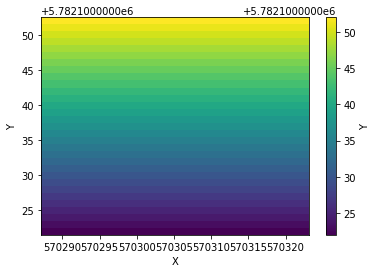

In [15]:
ql.Y.plot(x='X',y='Y')

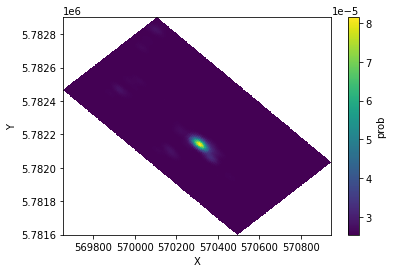

In [16]:
loc_map.prob.plot(x='X',y='Y')

In [312]:
print(loc_map.Y.min()-ql.Y.min())

<xarray.DataArray 'Y' ()>
array(-519.5)


In [30]:
ql

<xarray.Dataset>
Dimensions:  (y: 31, x: 36)
Coordinates:
    X        (y, x) float64 5.703e+05 5.703e+05 ... 5.703e+05 5.703e+05
    Y        (y, x) float64 5.782e+06 5.782e+06 ... 5.782e+06 5.782e+06
Dimensions without coordinates: y, x
Data variables:
    prob     (y, x) float64 0.001886 0.0 0.0 0.0 ... 0.002981 0.001419 0.0 0.0

In [36]:
ql.X.min()-pos.X

<xarray.DataArray 'X' ()>
array(-25.)
Coordinates:
    X        float32 5.703e+05
    Y        float32 5.782e+06

In [42]:
qs

<xarray.Dataset>
Dimensions:  (z: 1116)
Coordinates:
    X        (z) float64 5.703e+05 5.703e+05 5.703e+05 ... 5.703e+05 5.703e+05
    Y        (z) float64 5.782e+06 5.782e+06 5.782e+06 ... 5.782e+06 5.782e+06
  * z        (z) MultiIndex
  - y        (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 30 30 30 30 30 30 30 30 30 30
  - x        (z) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
Data variables:
    prob     (z) float64 0.001886 0.0 0.0 0.0 0.0 ... 0.002981 0.001419 0.0 0.0

In [43]:
ls=loc_map.prob.stack(z=("y","x"))

In [44]:
ls

<xarray.DataArray 'prob' (z: 38600)>
array([2.53285777e-05, 2.53285777e-05, 2.53285777e-05, ...,
       2.53285777e-05, 2.53285777e-05, 2.53285777e-05])
Coordinates:
    X        (z) float32 5.697e+05 5.697e+05 5.697e+05 ... 5.709e+05 5.709e+05
    Y        (z) float32 5.782e+06 5.782e+06 5.782e+06 ... 5.782e+06 5.782e+06
  * z        (z) MultiIndex
  - y        (z) int64 0 0 0 0 0 0 0 0 0 ... 192 192 192 192 192 192 192 192 192
  - x        (z) int64 0 1 2 3 4 5 6 7 8 ... 191 192 193 194 195 196 197 198 199

In [77]:
qs

<xarray.Dataset>
Dimensions:  (z: 1116)
Coordinates:
    X        (z) float64 5.703e+05 5.703e+05 5.703e+05 ... 5.703e+05 5.703e+05
    Y        (z) float64 5.782e+06 5.782e+06 5.782e+06 ... 5.782e+06 5.782e+06
  * z        (z) MultiIndex
  - y        (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 30 30 30 30 30 30 30 30 30 30
  - x        (z) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
Data variables:
    prob     (z) float64 0.001886 0.0 0.0 0.0 0.0 ... 0.002981 0.001419 0.0 0.0

In [97]:
out=sc.interpolate.griddata((qs.X.values,qs.Y.values),qs.prob.values,(ls.X.values,ls.Y.values))

In [98]:
out.max()

nan

In [99]:
res=ls.to_dataset()
res['out']=('z',out)
res

<xarray.Dataset>
Dimensions:  (z: 38600)
Coordinates:
    X        (z) float32 5.697e+05 5.697e+05 5.697e+05 ... 5.709e+05 5.709e+05
    Y        (z) float32 5.782e+06 5.782e+06 5.782e+06 ... 5.782e+06 5.782e+06
  * z        (z) MultiIndex
  - y        (z) int64 0 0 0 0 0 0 0 0 0 ... 192 192 192 192 192 192 192 192 192
  - x        (z) int64 0 1 2 3 4 5 6 7 8 ... 191 192 193 194 195 196 197 198 199
Data variables:
    prob     (z) float64 2.533e-05 2.533e-05 2.533e-05 ... 2.533e-05 2.533e-05
    out      (z) float64 nan nan nan nan nan nan nan ... nan nan nan nan nan nan

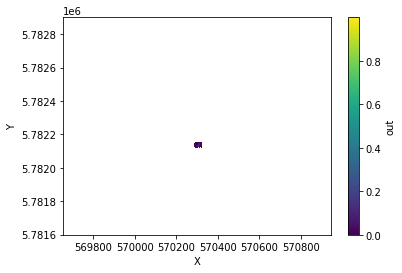

In [100]:
(res.unstack('z').out).plot(x='X',y='Y')